# Trained Models VGG19, ResNet50, ConvNext

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir ~/.kaggle

In [3]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d nirmalsankalana/crop-pest-and-disease-detection

 99% 1.23G/1.25G [00:18<00:00, 50.7MB/s]
100% 1.25G/1.25G [00:18<00:00, 71.7MB/s]


In [6]:
import os
import zipfile

# Create the folder where you want to unzip the file
folder_name = '/content/dataset'
os.makedirs(folder_name, exist_ok=True)

# Unzip the file into the created folder
zip_file = '/content/crop-pest-and-disease-detection.zip'
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(folder_name)

# Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.convnext import ConvNeXtBase


from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import accuracy_score

# Preparing Dataset

In [8]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             width_shift_range=0.2,
                             validation_split=0.2,
                             )

In [9]:
import os
from PIL import Image
import numpy as np
import shutil

data_dir=r'/content/dataset'
bad_img_list=[]
total=0
good=0
bad=0
classes=sorted(os.listdir(data_dir))
for klass in classes:
    good_class=0
    bad_class=0
    total_class=0
    msg=f'processing class {klass}'
    print(msg, '\r', end= '')
    classpath=os.path.join(data_dir, klass)
    flist=sorted(os.listdir(classpath))
    for f in flist:
        total +=1
        total_class +=1
        fpath=os.path.join(classpath,f)
        try:
            img= Image.open(fpath)
            array=np.asarray(img)
            good +=1
            good_class +=1
        except:
            bad_img_list.append(fpath)
            bad +=1
            bad_class +=1

    msg=f'class {klass} contains {total_class} files, {good_class} are valid image files and {bad_class} defective image files'
    print (msg)
msg=f'the dataset contains {total} image files, {good} are valid image files and {bad} are defective image files'
print (msg)
if bad>0:
    ans=input('to print a list of defective image files enter P, to not print press Enter')
    if ans == 'P' or ans == 'p':
        for f in bad_img_list:
            print (f)

class Cashew anthracnose contains 1729 files, 1729 are valid image files and 0 defective image files
class Cashew gumosis contains 392 files, 392 are valid image files and 0 defective image files
class Cashew healthy contains 1368 files, 1368 are valid image files and 0 defective image files
class Cashew leaf miner contains 1378 files, 1378 are valid image files and 0 defective image files
class Cashew red rust contains 1682 files, 1682 are valid image files and 0 defective image files
class Cassava bacterial blight contains 2614 files, 2614 are valid image files and 0 defective image files
class Cassava brown spot contains 1481 files, 1481 are valid image files and 0 defective image files
class Cassava green mite contains 1015 files, 1015 are valid image files and 0 defective image files
class Cassava healthy contains 1193 files, 1193 are valid image files and 0 defective image files
class Cassava mosaic contains 1205 files, 1205 are valid image files and 0 defective image files
class

In [10]:
# this code creates a corrected dataset with the defective image files removed
# you can use this dataset to create a model.
working_dir=r'/content/working_dataset'
corrected_dir=os.path.join(working_dir, 'corrected_dataset') # where the corrected dataset will be stored
copied_count = 0
if os.path.isdir(corrected_dir):
    shutil.rmtree(corrected_dir) # make sure the corrected_dir is empty
os.mkdir(corrected_dir)
for klass in classes:
    classpath=os.path.join(data_dir, klass)
    dest_classpath=os.path.join(corrected_dir, klass)
    os.mkdir(dest_classpath)
    flist= os.listdir(classpath)
    for f in flist:
        fpath=os.path.join(classpath,f)
        dest_fpath=os.path.join(dest_classpath,f)
        if fpath not in bad_img_list:
            shutil.copy(fpath, dest_fpath)
            copied_count +=1
msg=f'{copied_count} valid image files were stored in {corrected_dir}'
print(msg)

25126 valid image files were stored in /content/working_dataset/corrected_dataset


In [11]:
batch_size = 16

training_generator = datagen.flow_from_directory(
    corrected_dir,
    target_size=(224,224),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training',
)

validation_generator = datagen.flow_from_directory(
    corrected_dir,
    target_size=(224, 224),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation',
)

Found 20110 images belonging to 22 classes.
Found 5016 images belonging to 22 classes.


In [12]:
def cnn_model(base_model):
    for layer in base_model.layers:
        layer.trainable = False

    # Classifier
    num_classes = 22
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(units=1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(units=512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    pred = layers.Dense(units=num_classes, activation='softmax')(x)

    # Model
    model = models.Model(inputs=base_model.input, outputs=pred)

    # Compilation
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [13]:
# Instances of the pre-trained models and compile them
vgg19_model = cnn_model(VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3)))
resnet50_model = cnn_model(ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3)))
convnext_base_model = cnn_model(ConvNeXtBase(include_top=False, weights='imagenet', input_shape=(224,224,3)))

350926856/350926856 [==============================] - 2s 0us/step


In [14]:
models_dict = {
    'VGG19': vgg19_model,
    'ResNet50': resnet50_model,
    'ConvNextBase': convnext_base_model,
}

Training VGG19
Epoch 1/10
1257/1257 [==============================] - 374s 290ms/step - loss: 1.3655 - accuracy: 0.5775 - val_loss: 1.0507 - val_accuracy: 0.6316 - lr: 0.0010
Epoch 2/10
1257/1257 [==============================] - 360s 286ms/step - loss: 0.9376 - accuracy: 0.6820 - val_loss: 1.0091 - val_accuracy: 0.6659 - lr: 0.0010
Epoch 3/10
1257/1257 [==============================] - 357s 284ms/step - loss: 0.8622 - accuracy: 0.7048 - val_loss: 1.0897 - val_accuracy: 0.6483 - lr: 0.0010
Epoch 4/10
1257/1257 [==============================] - 357s 284ms/step - loss: 0.8310 - accuracy: 0.7173 - val_loss: 0.9600 - val_accuracy: 0.6734 - lr: 0.0010
Epoch 5/10
1257/1257 [==============================] - 358s 285ms/step - loss: 0.8132 - accuracy: 0.7271 - val_loss: 1.0018 - val_accuracy: 0.6653 - lr: 0.0010
Epoch 6/10
1257/1257 [==============================] - 368s 293ms/step - loss: 0.7962 - accuracy: 0.7354 - val_loss: 1.0488 - val_accuracy: 0.6715 - lr: 0.0010
Epoch 7/10
1257/125

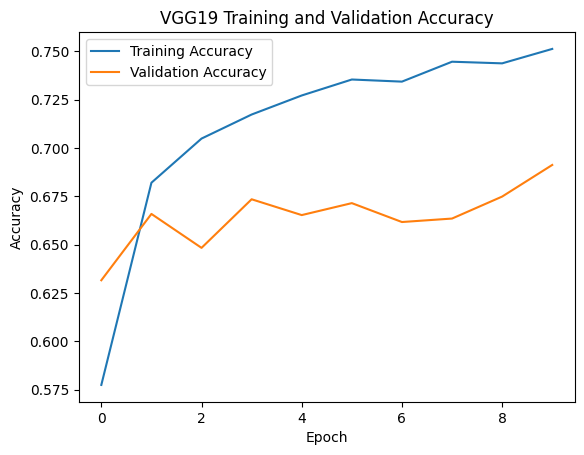

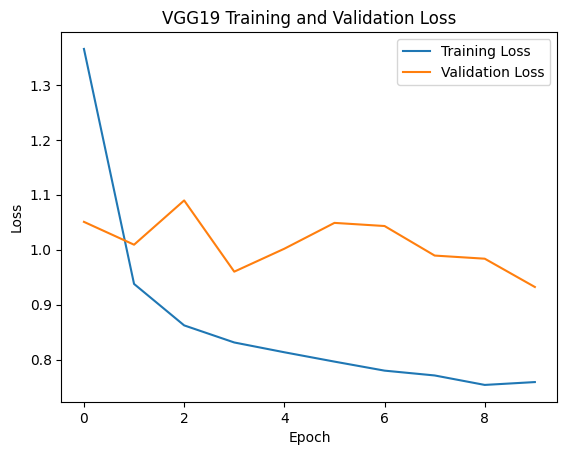

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training ResNet50
Epoch 1/10
1257/1257 [==============================] - 373s 292ms/step - loss: 1.1611 - accuracy: 0.6214 - val_loss: 0.9472 - val_accuracy: 0.6744 - lr: 0.0010
Epoch 2/10
1257/1257 [==============================] - 366s 291ms/step - loss: 0.7991 - accuracy: 0.7244 - val_loss: 0.8765 - val_accuracy: 0.6738 - lr: 0.0010
Epoch 3/10
1257/1257 [==============================] - 352s 280ms/step - loss: 0.7429 - accuracy: 0.7434 - val_loss: 0.9393 - val_accuracy: 0.6986 - lr: 0.0010
Epoch 4/10
1257/1257 [==============================] - 353s 281ms/step - loss: 0.6868 - accuracy: 0.7634 - val_loss: 0.9711 - val_accuracy: 0.6978 - lr: 0.0010
Epoch 5/10
1257/1257 [==============================] - 352s 280ms/step - loss: 0.6889 - accuracy: 0.7650 - val_loss: 0.8640 - val_accuracy: 0.7163 - lr: 0.0010
Epoch 6/10
1257/1257 [==============================] - 353s 281ms/step - loss: 0.6641 - accuracy: 0.7687 - val_loss: 1.1187 - val_accuracy: 0.7051 - lr: 0.0010
Epoch 7/10
1257/

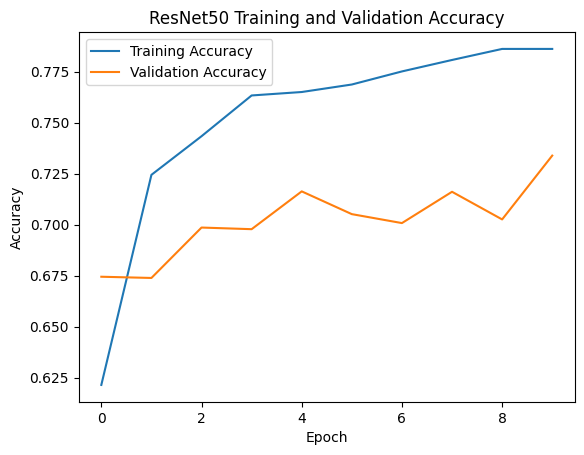

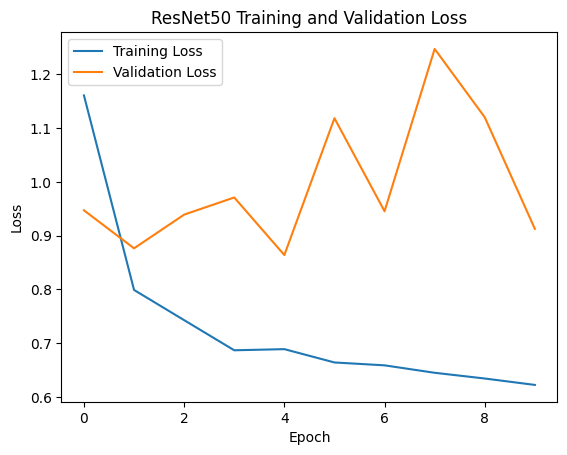

Training ConvNextBase
Epoch 1/10
1257/1257 [==============================] - 574s 440ms/step - loss: 1.0185 - accuracy: 0.6524 - val_loss: 0.7818 - val_accuracy: 0.6880 - lr: 0.0010
Epoch 2/10
1257/1257 [==============================] - 504s 401ms/step - loss: 0.7099 - accuracy: 0.7460 - val_loss: 0.7505 - val_accuracy: 0.7071 - lr: 0.0010
Epoch 3/10
1257/1257 [==============================] - 502s 399ms/step - loss: 0.6638 - accuracy: 0.7628 - val_loss: 0.8456 - val_accuracy: 0.6846 - lr: 0.0010
Epoch 4/10
1257/1257 [==============================] - 502s 399ms/step - loss: 0.6153 - accuracy: 0.7797 - val_loss: 0.9060 - val_accuracy: 0.6758 - lr: 0.0010
Epoch 5/10
1257/1257 [==============================] - 500s 398ms/step - loss: 0.6045 - accuracy: 0.7854 - val_loss: 0.8927 - val_accuracy: 0.6647 - lr: 0.0010
Epoch 6/10
1257/1257 [==============================] - 502s 399ms/step - loss: 0.5754 - accuracy: 0.7973 - val_loss: 0.8777 - val_accuracy: 0.7041 - lr: 0.0010
Epoch 7/10
1

In [ ]:
epochs = 10
for model_name, model in models_dict.items():
  print(f"Training {model_name}")
  callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-10),
             EarlyStopping(monitor='val_loss', patience=15)]
  history = model.fit(
      training_generator,
      epochs=epochs,
      validation_data=validation_generator,
      callbacks=callbacks,
    )

  # Plotting the training history
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title(f'{model_name} Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()


  # Plotting the loss history
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title(f'{model_name} Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  model.save(f'/content/drive/MyDrive/Corvit_AI/crop_disease/models/{model_name}.h5')